In [2]:
import loader
import plot
import helpers
import importlib
import joblib
importlib.reload(loader)
importlib.reload(plot)
importlib.reload(helpers)
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from collections import defaultdict
import warnings
from matplotlib import cm
from sklearn.decomposition import FastICA, PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.random_projection import SparseRandomProjection
from kneed import KneeLocator
from scipy.stats import describe, kurtosis
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split, StratifiedKFold, learning_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import RMSprop
from sklearn.ensemble import AdaBoostClassifier
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import pairwise_distances, mean_squared_error
from sklearn.mixture import GaussianMixture
from yellowbrick.cluster import InterclusterDistance


In [3]:
data = loader.load_cancer_data()
features = [col for col in data.columns if col != "target"]
X = data[features]
y = data["target"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [4]:
data[data["target"] == 1].count()

radius mean                212
texture mean               212
perimeter mean             212
area mean                  212
smoothness mean            212
compactness mean           212
concavity mean             212
concave points mean        212
symmetry mean              212
fractal dimension mean     212
radius se                  212
texture se                 212
perimeter se               212
area se                    212
smoothness se              212
compactness se             212
concavity se               212
concave points se          212
symmetry se                212
fractal dimension se       212
radius worst               212
texture worst              212
perimeter worst            212
area worst                 212
smoothness worst           212
compactness worst          212
concavity worst            212
concave points worst       212
symmetry worst             212
fractal dimension worst    212
target                     212
dtype: int64

In [5]:
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

In [6]:
n_clusters = [i for i in range(2, 31)]

In [7]:
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 30, 40, 50, 60, 70, 80, 90, 100]

<h1>K-Means</h1>

In [23]:
km_res = defaultdict(dict)
for k in n_clusters:
    km = KMeans(n_clusters=k,
                random_state=0,
               )
    start = time.perf_counter()
    km.fit(X_norm)
    run_time = time.perf_counter() - start
    y_km = km.predict(X_norm)
    km_res[k]['dist'] = km.inertia_
    km_res[k]['time'] = run_time
    km_res[k]['sil'] = silhouette_score(X_norm, y_km, random_state=0)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        km_res[k]['ami'] = ami(y, y_km)
    print('done k=%i in %.3f sec' % (k, run_time))

done k=2 in 0.031 sec
done k=3 in 0.063 sec
done k=4 in 0.053 sec
done k=5 in 0.064 sec
done k=6 in 0.067 sec
done k=7 in 0.072 sec
done k=8 in 0.128 sec
done k=9 in 0.092 sec
done k=10 in 0.102 sec
done k=12 in 0.104 sec
done k=14 in 0.116 sec
done k=16 in 0.116 sec
done k=18 in 0.130 sec
done k=20 in 0.128 sec
done k=30 in 0.165 sec
done k=40 in 0.186 sec
done k=50 in 0.233 sec
done k=60 in 0.306 sec
done k=70 in 0.311 sec
done k=80 in 0.354 sec
done k=90 in 0.373 sec
done k=100 in 0.401 sec


In [24]:
joblib.dump(km_res, "results/k_means_cancer.pkl")

['results/k_means_cancer.pkl']

In [23]:
km_res = joblib.load("results/k_means_cancer.pkl")

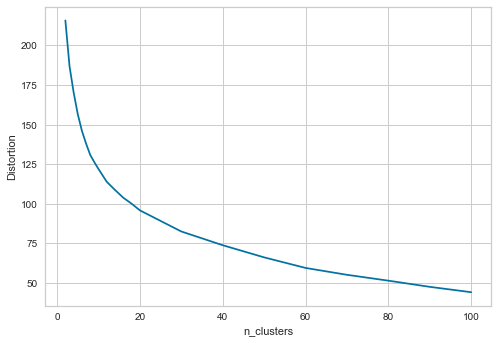

In [24]:
plt.plot(n_clusters, [km_res[k]['dist'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Distortion')
plt.show()

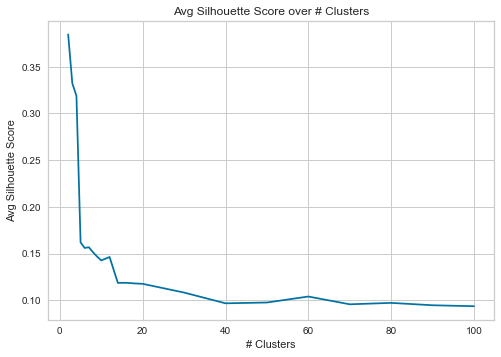

In [26]:
plt.plot(n_clusters, [km_res[k]['sil'] for k in n_clusters])
plt.title('Avg Silhouette Score over # Clusters')
plt.xlabel('# Clusters')
plt.ylabel('Avg Silhouette Score')
plt.show()

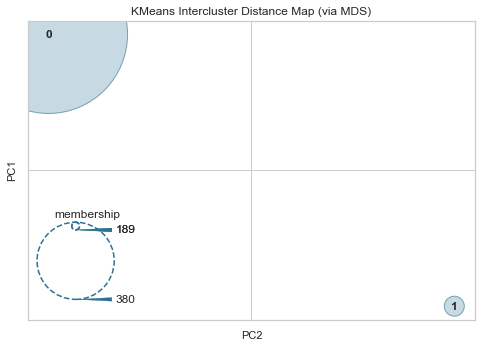

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [67]:
km_model = KMeans(n_clusters=2)
visualizer = InterclusterDistance(km_model)
visualizer.fit(X_norm)
visualizer.show()

In [79]:
y_pred = km_model.predict(X_norm)
accuracy_score(y, y_pred)

0.9279437609841827

<h1>EM</h1>

In [28]:
em_res = defaultdict(dict)
for k in n_clusters:
    gm = GaussianMixture(
        n_components=k,
        random_state=0,
        init_params='kmeans',
    )
    start = time.perf_counter()
    gm.fit(X_norm)
    run_time = time.perf_counter() - start
    y_gm = gm.predict(X_norm)
    em_res[k]['bic'] = gm.bic(X_norm)
    em_res[k]['aic'] = gm.aic(X_norm)
    em_res[k]['ll'] = gm.score(X_norm)
    em_res[k]['time'] = run_time
    em_res[k]['sil'] = silhouette_score(X_norm, y_gm, random_state=0)
    print('done k=%i in %.3f sec' % (k, run_time))

joblib.dump(em_res, "results/em_cancer.pkl")

done k=2 in 0.019 sec
done k=3 in 0.024 sec
done k=4 in 0.025 sec
done k=5 in 0.040 sec
done k=6 in 0.034 sec
done k=7 in 0.041 sec
done k=8 in 0.047 sec
done k=9 in 0.057 sec
done k=10 in 0.050 sec
done k=12 in 0.053 sec
done k=14 in 0.037 sec
done k=16 in 0.073 sec
done k=18 in 0.071 sec
done k=20 in 0.063 sec
done k=30 in 0.037 sec
done k=40 in 0.047 sec
done k=50 in 0.057 sec
done k=60 in 0.064 sec
done k=70 in 0.092 sec
done k=80 in 0.099 sec
done k=90 in 0.104 sec
done k=100 in 0.099 sec


['results/em_cancer.pkl']

In [27]:
em_res = joblib.load("results/em_cancer.pkl")

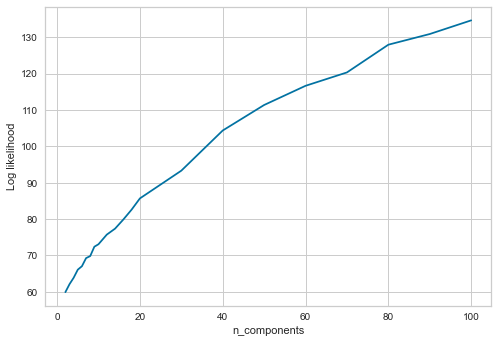

In [28]:
plt.plot(n_clusters, [em_res[k]['ll'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Log likelihood')
plt.show()

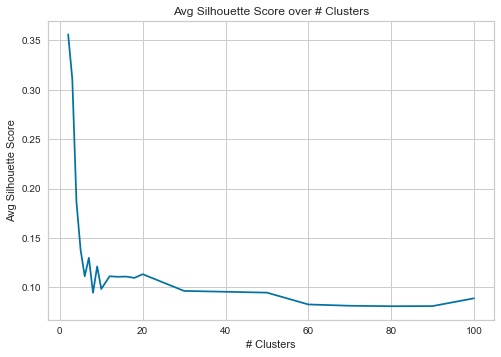

In [29]:
plt.plot(n_clusters, [em_res[k]['sil'] for k in n_clusters])
plt.title('Avg Silhouette Score over # Clusters')
plt.xlabel('# Clusters')
plt.ylabel('Avg Silhouette Score')
plt.show()

In [31]:
em = GaussianMixture(
    n_components=2,
    random_state=0,
    init_params='kmeans',
)
em.fit(X_norm)
y_pred = em.predict(X_norm)
accuracy_score(y, y_pred)

0.9420035149384886

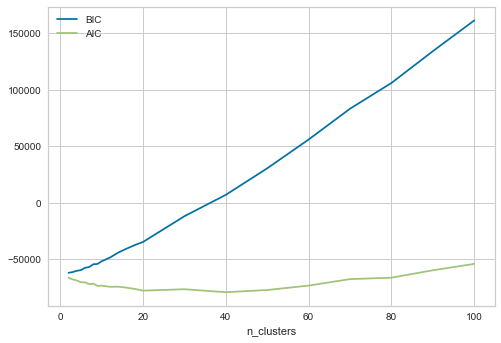

In [31]:
plt.plot(n_clusters, [em_res[k]['bic'] for k in n_clusters], label='BIC')
plt.plot(n_clusters, [em_res[k]['aic'] for k in n_clusters], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_clusters')
plt.show()

<h1>PCA</h1>

In [32]:
component_counts = [n for n in range(1, 31)]
pca_mse = []

for cc in component_counts:
    tmp_pca = PCA(
        random_state=0,
        n_components=cc,
    )
    start = time.perf_counter()
    tmp_X_tr = tmp_pca.fit_transform(X_norm)
    run_time = time.perf_counter() - start
    
    reconstructed_data = tmp_pca.inverse_transform(tmp_X_tr)
    error = mean_squared_error(X_norm, reconstructed_data)
    pca_mse.append(error)
    
    print(f'done n_components={cc} in {run_time} sec')

done n_components=1 in 0.007359780996921472 sec
done n_components=2 in 0.0032046169944806024 sec
done n_components=3 in 0.0020538370008580387 sec
done n_components=4 in 0.0023903380060801283 sec
done n_components=5 in 0.002295769998454489 sec
done n_components=6 in 0.002617339006974362 sec
done n_components=7 in 0.0026391319988761097 sec
done n_components=8 in 0.002791888007777743 sec
done n_components=9 in 0.0030753449973417446 sec
done n_components=10 in 0.002494562999345362 sec
done n_components=11 in 0.0022269110049819574 sec
done n_components=12 in 0.0025211309985024855 sec
done n_components=13 in 0.002294279998750426 sec
done n_components=14 in 0.0025752049987204373 sec
done n_components=15 in 0.002721530996495858 sec
done n_components=16 in 0.003690298995934427 sec
done n_components=17 in 0.00305664399638772 sec
done n_components=18 in 0.003299482006696053 sec
done n_components=19 in 0.0032527930015930906 sec
done n_components=20 in 0.0029274760017869994 sec
done n_components=21

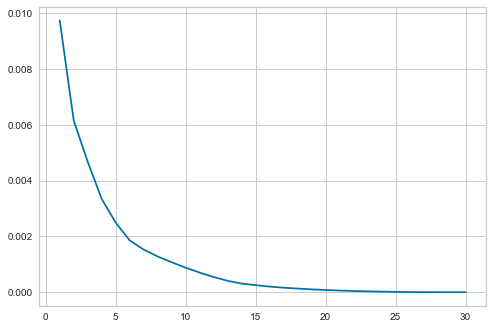

In [33]:
plt.plot(component_counts, pca_mse)

In [33]:
pca = PCA(
    n_components=None,
    random_state=0,
)
pca.fit(X_norm)

PCA(random_state=0)

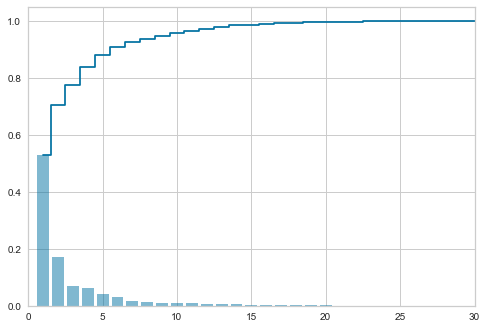

In [35]:
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, 
        align='center', alpha=0.5, label='Individual explained variance')
plt.step(range(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_), 
        where='mid', label='Cumulative explained variance')
plt.xlim([0, 30])
plt.show()

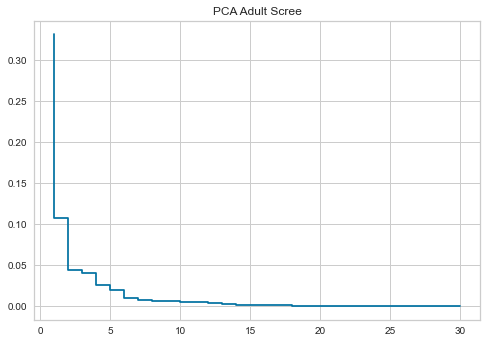

In [36]:
plt.step(range(1, pca.n_components_ + 1), pca.explained_variance_)
plt.title("PCA Adult Scree")
plt.show()

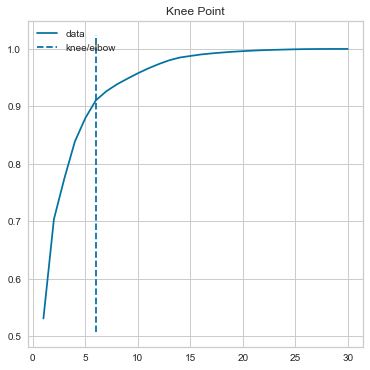

In [37]:
kneedle = KneeLocator(range(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_), curve="concave", direction="increasing")
kneedle.plot_knee()

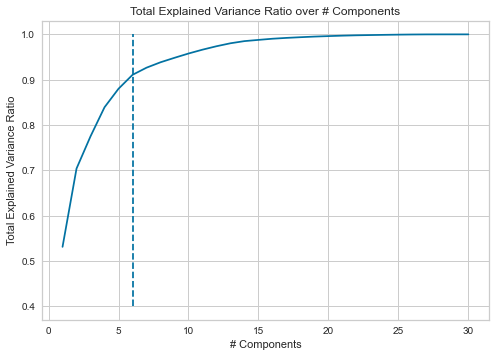

In [35]:
plt.plot(range(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_))
plt.title('Total Explained Variance Ratio over # Components')
plt.xlabel('# Components')
plt.ylabel('Total Explained Variance Ratio')
plt.vlines(6, 0.4, 1, linestyles='dashed')

plt.show()

In [38]:
kneedle.knee

6

<h1>ICA</h1>

In [12]:
standardizer = StandardScaler()
X_preprocessed = standardizer.fit_transform(X_norm)

In [13]:
component_counts = [n for n in range(1, 41)]
mean_kurtosis = {}
ica_mse = []

for cc in component_counts:
    tmp_ica = FastICA(
        random_state=0,
        n_components=cc,
    )
    start = time.perf_counter()
    tmp_X_tr = tmp_ica.fit_transform(X_preprocessed)
    run_time = time.perf_counter() - start
    mean_kurtosis[cc] = kurtosis(tmp_X_tr).mean()
    
    reconstructed_data = tmp_ica.inverse_transform(tmp_X_tr)
    error = mean_squared_error(X_norm, reconstructed_data)
    ica_mse.append(error)
    
    print(f'done n_components={cc} in {run_time} sec')

print(mean_kurtosis)

done n_components=1 in 0.003119891000096686 sec
done n_components=2 in 0.003120465000392869 sec
done n_components=3 in 0.00628004099962709 sec
done n_components=4 in 0.003968875999817101 sec
done n_components=5 in 0.005984534999697644 sec
done n_components=6 in 0.005034786000578606 sec
done n_components=7 in 0.009830068999690411 sec
done n_components=8 in 0.007816723999894748 sec
done n_components=9 in 0.018555354999989504 sec
done n_components=10 in 0.009680948000095668 sec
done n_components=11 in 0.01354747799996403 sec
done n_components=12 in 0.01615570600006322 sec
done n_components=13 in 0.021899708000091778 sec
done n_components=14 in 0.015867391000028874 sec
done n_components=15 in 0.020866466999905242 sec
done n_components=16 in 0.01953264300027513 sec
done n_components=17 in 0.026365090999206586 sec
done n_components=18 in 0.02645173899963993 sec
done n_components=19 in 0.0328181160002714 sec
done n_components=20 in 0.04059102900009748 sec
done n_components=21 in 0.04977769099

/Users/eoh/opt/anaconda3/envs/school/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


done n_components=25 in 0.17303638599969418 sec
done n_components=26 in 0.04598928599989449 sec
done n_components=27 in 0.07268817699969077 sec
done n_components=28 in 0.0584817960007058 sec
done n_components=29 in 0.0918330459999197 sec
done n_components=30 in 0.08213174200045614 sec
done n_components=31 in 0.08198642499974085 sec


/Users/eoh/opt/anaconda3/envs/school/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:470: UserWarning: n_components is too large: it will be set to 30
  % n_components
/Users/eoh/opt/anaconda3/envs/school/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:470: UserWarning: n_components is too large: it will be set to 30
  % n_components
/Users/eoh/opt/anaconda3/envs/school/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:470: UserWarning: n_components is too large: it will be set to 30
  % n_components


done n_components=32 in 0.10074979499950132 sec
done n_components=33 in 0.101640717999544 sec
done n_components=34 in 0.09723883100014064 sec


/Users/eoh/opt/anaconda3/envs/school/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:470: UserWarning: n_components is too large: it will be set to 30
  % n_components
/Users/eoh/opt/anaconda3/envs/school/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:470: UserWarning: n_components is too large: it will be set to 30
  % n_components
/Users/eoh/opt/anaconda3/envs/school/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:470: UserWarning: n_components is too large: it will be set to 30
  % n_components


done n_components=35 in 0.10017102199981309 sec
done n_components=36 in 0.09806213399951957 sec
done n_components=37 in 0.0953018959999099 sec


/Users/eoh/opt/anaconda3/envs/school/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:470: UserWarning: n_components is too large: it will be set to 30
  % n_components
/Users/eoh/opt/anaconda3/envs/school/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:470: UserWarning: n_components is too large: it will be set to 30
  % n_components
/Users/eoh/opt/anaconda3/envs/school/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:470: UserWarning: n_components is too large: it will be set to 30
  % n_components


done n_components=38 in 0.09043610699973215 sec
done n_components=39 in 0.09156684000026871 sec
done n_components=40 in 0.08774159000040527 sec
{1: 0.8954442846448756, 2: 2.6955041300504385, 3: 4.419710692518262, 4: 4.0098508908848025, 5: 6.353622065857497, 6: 6.025908679506563, 7: 8.934435325912562, 8: 9.05343217766091, 9: 10.63212124354375, 10: 12.130069622234732, 11: 17.35072440815451, 12: 20.722507124579867, 13: 20.311790642224388, 14: 19.91703997358955, 15: 19.54962210748401, 16: 20.37386966868166, 17: 23.95922622025923, 18: 27.12481563333022, 19: 25.93495195156608, 20: 27.94381574975368, 21: 28.897535310214305, 22: 29.716378278591147, 23: 30.46867556466768, 24: 31.29371901945973, 25: 33.413729427355534, 26: 32.80095619921816, 27: 32.402835705879234, 28: 33.33978181433436, 29: 34.89043882492287, 30: 34.31667227317327, 31: 34.31667227317327, 32: 34.31667227317327, 33: 34.31667227317327, 34: 34.31667227317327, 35: 34.31667227317327, 36: 34.31667227317327, 37: 34.31667227317327, 38: 

/Users/eoh/opt/anaconda3/envs/school/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:470: UserWarning: n_components is too large: it will be set to 30
  % n_components


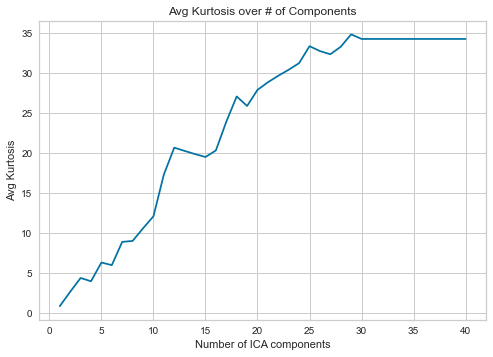

In [36]:
pd.Series(mean_kurtosis).plot()
plt.title('Avg Kurtosis over # of Components')
plt.ylabel('Avg Kurtosis')
plt.xlabel('Number of ICA components')
plt.show()

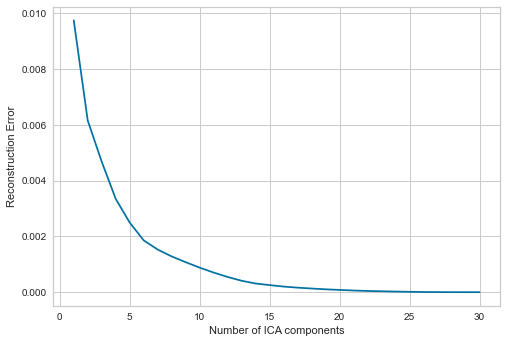

In [117]:
plt.ylabel('Reconstruction Error')
plt.xlabel('Number of ICA components')
plt.plot(component_counts, ica_mse)
plt.show()

<h1>RP</h1>

In [37]:
component_counts = [n for n in range(1, 31)]

rp_res = defaultdict(dict)

rp_mse = []
mse = []

for cc in component_counts:

    srp = SparseRandomProjection(n_components=cc)
    start = time.perf_counter()
    srp.fit(X_norm)
    run_time = time.perf_counter() - start

    components = srp.components_.toarray()
    p_inverse = np.linalg.pinv(components.T)
    reduced_data = srp.transform(X_norm)
#     reconstructed_data = reduced_data.dot(srp.components_) + np.mean(X_norm, axis = 0)

    reconstructed_data = reduced_data.dot(p_inverse)
    error = mean_squared_error(X_norm, reconstructed_data)
    rp_mse.append(error)

#     srp = SparseRandomProjection(n_components=cc)
#     Xt = srp.fit_transform(X_norm)
#     Xr = helpers.reconstructit(srp.components_, Xt)
#     mse.append(mean_squared_error(X_norm, Xr))

    print(f'done n_components={cc} in {run_time} sec')


# random_projection = SparseRandomProjection(n_components=5)

# random_projection.fit(data)
# components =  random_projection.components_.toarray() # shape=(5, 11) 
# p_inverse = np.linalg.pinv(components.T) # shape=(5, 11) 

# #now get the transformed data using the projection components
# reduced_data = random_projection.transform(data) #shape=(4898, 5) 
# reconstructed= reduced_data.dot(p_inverse)  #shape=(4898, 11) 
# assert  reduced_data.shape ==  reconstructed.shape
# error = mean_squared_error(data, reconstructed)

done n_components=1 in 0.0008822109957691282 sec
done n_components=2 in 0.0007755070109851658 sec
done n_components=3 in 0.0008809790015220642 sec
done n_components=4 in 0.0008678390004206449 sec
done n_components=5 in 0.0006957230070838705 sec
done n_components=6 in 0.0007608520099893212 sec
done n_components=7 in 0.000767089004511945 sec
done n_components=8 in 0.000820747998659499 sec
done n_components=9 in 0.0009302959952037781 sec
done n_components=10 in 0.001107288000639528 sec
done n_components=11 in 0.0007868079992476851 sec
done n_components=12 in 0.0008319449989357963 sec
done n_components=13 in 0.0009135909931501374 sec
done n_components=14 in 0.0009630120039219037 sec
done n_components=15 in 0.000765914999647066 sec
done n_components=16 in 0.0008680219907546416 sec
done n_components=17 in 0.0009109640086535364 sec
done n_components=18 in 0.0009314300114056095 sec
done n_components=19 in 0.001101083995308727 sec
done n_components=20 in 0.0010920950007857755 sec
done n_compone

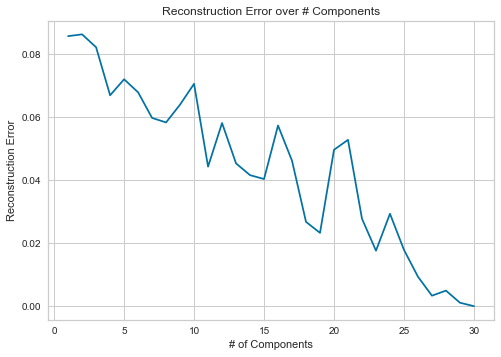

In [38]:
plt.plot(component_counts, rp_mse)
plt.xlabel('# of Components')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error over # Components')
plt.show()

<h1>SVD</h1>

In [49]:
component_counts = [n for n in range(1, 30)]
svd_mse = []

for cc in component_counts:

    svd = TruncatedSVD(n_components=cc)
    start = time.perf_counter()
    tmp_svd_Xt = svd.fit_transform(X_norm)
    run_time = time.perf_counter() - start
    
    reconstructed_data = svd.inverse_transform(tmp_svd_Xt)
    error = mean_squared_error(X_norm, reconstructed_data)
    svd_mse.append(error)
    print(f'done n_components={cc} in {run_time}')

done n_components=1 in 0.002705217993934639
done n_components=2 in 0.00227840400475543
done n_components=3 in 0.0017923699924722314
done n_components=4 in 0.0020410579891176894
done n_components=5 in 0.0020856460032518953
done n_components=6 in 0.002108179993228987
done n_components=7 in 0.0019582050008466467
done n_components=8 in 0.002489528007572517
done n_components=9 in 0.0024178230087272823
done n_components=10 in 0.0020153239893261343
done n_components=11 in 0.001971346006030217
done n_components=12 in 0.002341283005080186
done n_components=13 in 0.0021239339985186234
done n_components=14 in 0.0021954379917588085
done n_components=15 in 0.002163850993383676
done n_components=16 in 0.0022768369963159785
done n_components=17 in 0.0023143729922594503
done n_components=18 in 0.0026389760023448616
done n_components=19 in 0.0028075380105292425
done n_components=20 in 0.002631822004332207
done n_components=21 in 0.0025570689904270694
done n_components=22 in 0.0023089579917723313
done n

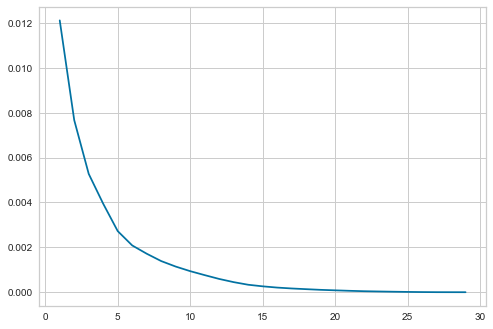

In [50]:
plt.plot(component_counts, svd_mse)
plt.show()

In [39]:
svd_29 = TruncatedSVD(n_components=29)
svd_29_Xt = svd_29.fit_transform(X_norm)

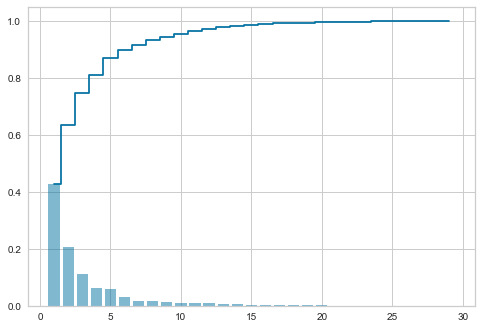

In [52]:
plt.bar(range(1, 30), svd_29.explained_variance_ratio_, 
        align='center', alpha=0.5, label='Individual explained variance')
plt.step(range(1, 30), np.cumsum(svd_29.explained_variance_ratio_), 
        where='mid', label='Cumulative explained variance')
plt.show()

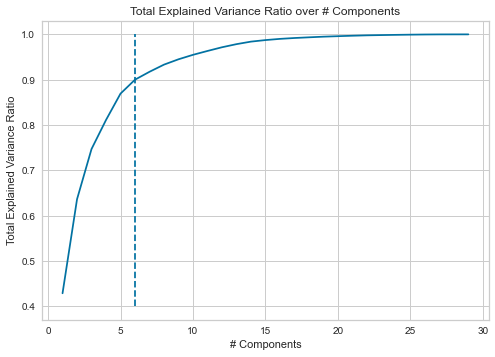

In [41]:
plt.plot(range(1, svd_29.components_.shape[0] + 1), np.cumsum(svd_29.explained_variance_ratio_))
plt.title('Total Explained Variance Ratio over # Components')
plt.xlabel('# Components')
plt.ylabel('Total Explained Variance Ratio')
plt.vlines(6, 0.4, 1, linestyles='dashed')

plt.show()

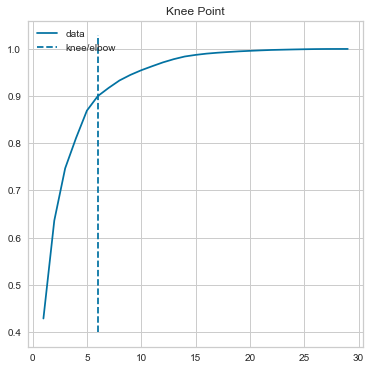

In [53]:
kneedle = KneeLocator(range(1, svd_29.components_.shape[0] + 1), np.cumsum(svd_29.explained_variance_ratio_), curve="concave", direction="increasing")
kneedle.plot_knee()

In [80]:
kneedle.knee

6

<h1>K-Means with PCA</h1>

In [54]:
km_pca_res = defaultdict(dict)
pca_6 = PCA(
    n_components=6,
    random_state=0,
)
pca_6_Xt = pca_6.fit_transform(X_norm)
for k in n_clusters:
    km = KMeans(n_clusters=k,
                random_state=0,
               )
    start = time.perf_counter()
    km.fit(pca_6_Xt)
    run_time = time.perf_counter() - start
    y_km = km.predict(pca_6_Xt)
    km_pca_res[k]['dist'] = km.inertia_
    km_pca_res[k]['time'] = run_time
    km_pca_res[k]['sil'] = silhouette_score(pca_6_Xt, y_km, random_state=0)
    print('done k=%i in %.3f sec' % (k, run_time))

joblib.dump(km_pca_res, "results/k_means_pca_cancer.pkl")

done k=2 in 0.033 sec
done k=3 in 0.054 sec
done k=4 in 0.052 sec
done k=5 in 0.078 sec
done k=6 in 0.072 sec
done k=7 in 0.071 sec
done k=8 in 0.085 sec
done k=9 in 0.076 sec
done k=10 in 0.087 sec
done k=12 in 0.097 sec
done k=14 in 0.098 sec
done k=16 in 0.102 sec
done k=18 in 0.107 sec
done k=20 in 0.116 sec
done k=30 in 0.144 sec
done k=40 in 0.184 sec
done k=50 in 0.208 sec
done k=60 in 0.246 sec
done k=70 in 0.285 sec
done k=80 in 0.302 sec
done k=90 in 0.329 sec
done k=100 in 0.356 sec


['results/k_means_pca_cancer.pkl']

In [43]:
km_pca_res = joblib.load('results/k_means_pca_cancer.pkl')

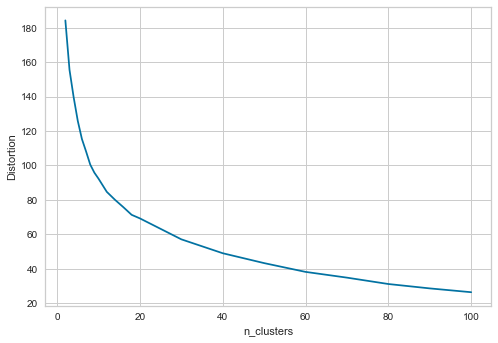

In [55]:
plt.plot(n_clusters, [km_pca_res[k]['dist'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Distortion')
plt.show()

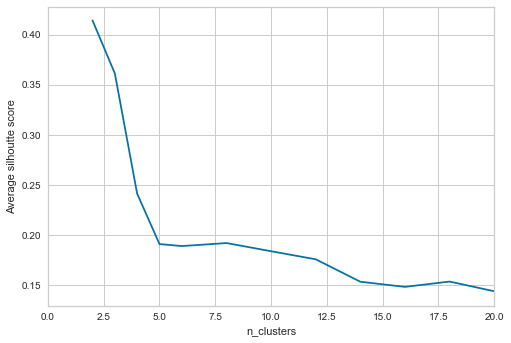

In [57]:
plt.plot(n_clusters, [km_pca_res[k]['sil'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Average silhoutte score')
plt.xlim([0, 20])
plt.show()

<h1>K-Means with ICA</h1>

In [15]:
ica29 = FastICA(
    random_state=0,
    n_components=29,
)
ica29_Xt = ica29.fit_transform(X_preprocessed)

In [123]:
ica10_Xt.shape

(569, 10)

In [126]:
components = [[] for i in range(len(ica10_Xt[0]))]
for i in range(569):
    tmp = ica10_Xt[i]
    for i in range(len(tmp)):
        components[i].append(tmp[i])

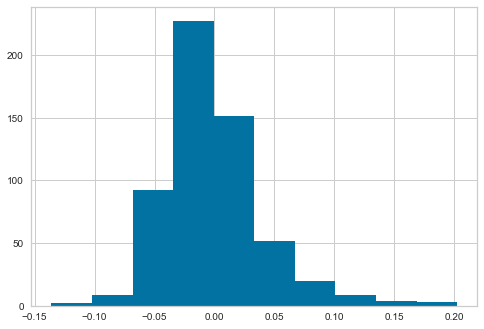

In [137]:
plt.hist(components[3])
plt.show()

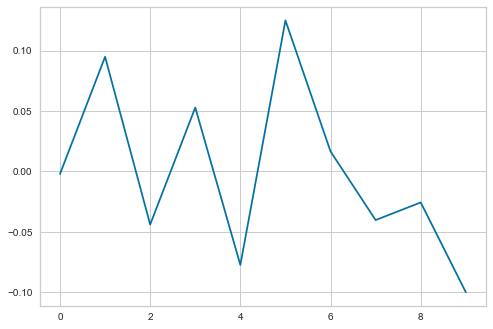

In [120]:
plt.plot(range(len(ica10_Xt[0])), ica10_Xt[0])
plt.show()

In [16]:
km_ica_res = defaultdict(dict)
ica29 = FastICA(
    random_state=0,
    n_components=29,
)
ica29_Xt = ica29.fit_transform(X_preprocessed)

for k in n_clusters:
    km = KMeans(n_clusters=k,
                random_state=0,
               )
    start = time.perf_counter()
    km.fit(ica29_Xt)
    run_time = time.perf_counter() - start
    y_km = km.predict(ica29_Xt)
    km_ica_res[k]['dist'] = km.inertia_
    km_ica_res[k]['time'] = run_time
    km_ica_res[k]['sil'] = silhouette_score(ica29_Xt, y_km, random_state=0)
    print('done k=%i in %.3f sec' % (k, run_time))

joblib.dump(km_ica_res, "results/k_means_ica_29_cancer.pkl")

done k=2 in 0.043 sec
done k=3 in 0.054 sec
done k=4 in 0.057 sec
done k=5 in 0.066 sec
done k=6 in 0.078 sec
done k=7 in 0.084 sec
done k=8 in 0.096 sec
done k=9 in 0.105 sec
done k=10 in 0.101 sec
done k=12 in 0.112 sec
done k=14 in 0.117 sec
done k=16 in 0.129 sec
done k=18 in 0.134 sec
done k=20 in 0.135 sec
done k=30 in 0.179 sec
done k=40 in 0.218 sec
done k=50 in 0.251 sec
done k=60 in 0.284 sec
done k=70 in 0.356 sec
done k=80 in 0.358 sec
done k=90 in 0.382 sec
done k=100 in 0.429 sec


['results/k_means_ica_29_cancer.pkl']

In [44]:
km_ica_res = joblib.load('results/k_means_ica_cancer.pkl')

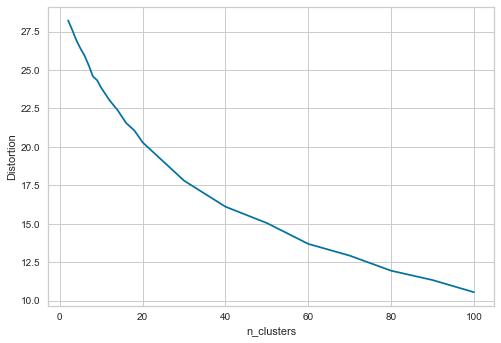

In [17]:
plt.plot(n_clusters, [km_ica_res[k]['dist'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Distortion')
plt.show()

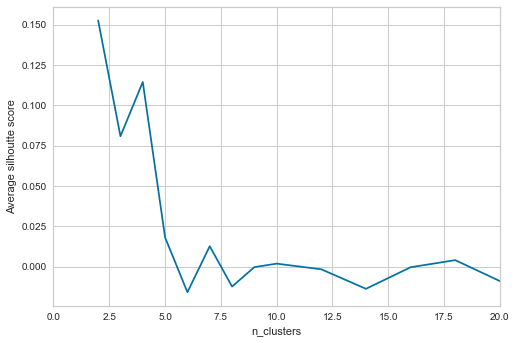

In [18]:
plt.plot(n_clusters, [km_ica_res[k]['sil'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Average silhoutte score')
plt.xlim([0, 20])
plt.show()

<h1>K-Means with RP</h1>

In [62]:
km_rp_res = defaultdict(dict)
rp7 = SparseRandomProjection(n_components=7, random_state = 0)

rp7_Xt = rp7.fit_transform(X_norm)

for k in n_clusters:
    km = KMeans(n_clusters=k,
                random_state=0,
               )
    start = time.perf_counter()
    km.fit(rp7_Xt)
    run_time = time.perf_counter() - start
    y_km = km.predict(rp7_Xt)
    km_rp_res[k]['dist'] = km.inertia_
    km_rp_res[k]['time'] = run_time
    km_rp_res[k]['sil'] = silhouette_score(rp7_Xt, y_km, random_state=0)
    print('done k=%i in %.3f sec' % (k, run_time))

joblib.dump(km_rp_res, "results/k_means_rp_cancer.pkl")

done k=2 in 0.028 sec
done k=3 in 0.048 sec
done k=4 in 0.052 sec
done k=5 in 0.052 sec
done k=6 in 0.071 sec
done k=7 in 0.076 sec
done k=8 in 0.079 sec
done k=9 in 0.077 sec
done k=10 in 0.099 sec
done k=12 in 0.081 sec
done k=14 in 0.087 sec
done k=16 in 0.107 sec
done k=18 in 0.104 sec
done k=20 in 0.120 sec
done k=30 in 0.151 sec
done k=40 in 0.182 sec
done k=50 in 0.209 sec
done k=60 in 0.269 sec
done k=70 in 0.302 sec
done k=80 in 0.309 sec
done k=90 in 0.343 sec
done k=100 in 0.368 sec


['results/k_means_rp_cancer.pkl']

In [45]:
km_rp_res = joblib.load('results/k_means_rp_cancer.pkl')

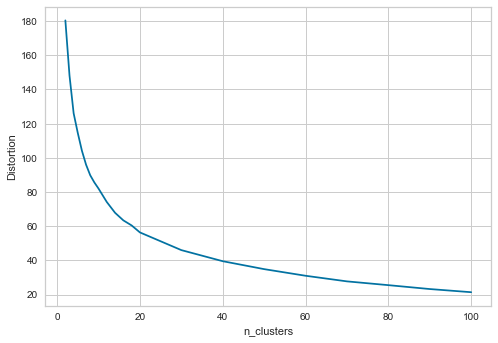

In [63]:
plt.plot(n_clusters, [km_rp_res[k]['dist'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Distortion')
plt.show()

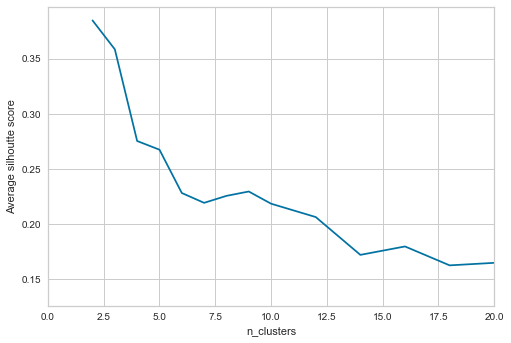

In [65]:
plt.plot(n_clusters, [km_rp_res[k]['sil'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Average silhoutte score')
plt.xlim([0, 20])
plt.show()

<h1>K-Means with SVD</h1>

In [81]:
km_svd_res = defaultdict(dict)
svd6 = TruncatedSVD(n_components=6, random_state = 0)

svd6_Xt = svd6.fit_transform(X_norm)

for k in n_clusters:
    km = KMeans(n_clusters=k,
                random_state=0,
               )
    start = time.perf_counter()
    km.fit(svd6_Xt)
    run_time = time.perf_counter() - start
    y_km = km.predict(svd6_Xt)
    km_svd_res[k]['dist'] = km.inertia_
    km_svd_res[k]['time'] = run_time
    km_svd_res[k]['sil'] = silhouette_score(svd6_Xt, y_km, random_state=0)
    print('done k=%i in %.3f sec' % (k, run_time))

joblib.dump(km_svd_res, "results/k_means_svd_cancer.pkl")

done k=2 in 0.028 sec
done k=3 in 0.055 sec
done k=4 in 0.054 sec
done k=5 in 0.069 sec
done k=6 in 0.067 sec
done k=7 in 0.075 sec
done k=8 in 0.067 sec
done k=9 in 0.077 sec
done k=10 in 0.085 sec
done k=12 in 0.091 sec
done k=14 in 0.102 sec
done k=16 in 0.116 sec
done k=18 in 0.100 sec
done k=20 in 0.113 sec
done k=30 in 0.134 sec
done k=40 in 0.167 sec
done k=50 in 0.204 sec
done k=60 in 0.247 sec
done k=70 in 0.285 sec
done k=80 in 0.312 sec
done k=90 in 0.349 sec
done k=100 in 0.375 sec


['results/k_means_svd_cancer.pkl']

In [46]:
km_svd_res = joblib.load('results/k_means_svd_cancer.pkl')

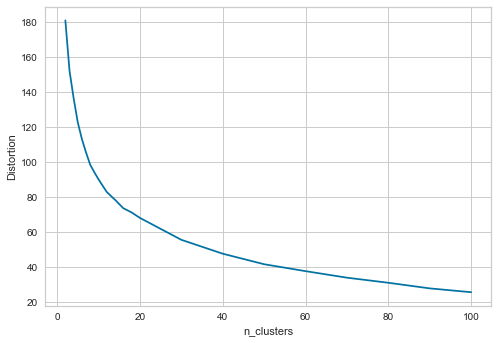

In [82]:
plt.plot(n_clusters, [km_svd_res[k]['dist'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Distortion')
plt.show()

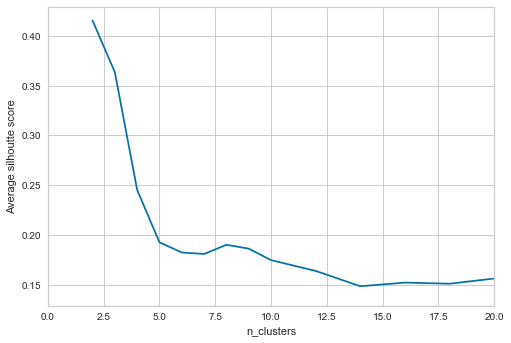

In [84]:
plt.plot(n_clusters, [km_svd_res[k]['sil'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Average silhoutte score')
plt.xlim([0, 20])
plt.show()

<h1>EM with PCA</h1>

In [85]:
em_pca_res = defaultdict(dict)
pca_6 = PCA(
    n_components=6,
    random_state=0,
)
pca_6_Xt = pca_6.fit_transform(X_norm)

for k in n_clusters:
    em = GaussianMixture(
        n_components=k,
        random_state=0,
        init_params='kmeans',
    )
    start = time.perf_counter()
    em.fit(pca_6_Xt)
    run_time = time.perf_counter() - start
    y_em = em.predict(pca_6_Xt)
    em_pca_res[k]['bic'] = em.bic(pca_6_Xt)
    em_pca_res[k]['aic'] = em.aic(pca_6_Xt)
    em_pca_res[k]['ll'] = em.score(pca_6_Xt)
    em_pca_res[k]['time'] = run_time
    em_pca_res[k]['sil'] = silhouette_score(pca_6_Xt, y_em, random_state=0)
    print('done k=%i in %.3f sec' % (k, run_time))

joblib.dump(em_pca_res, "results/em_pca_cancer.pkl")

done k=2 in 0.014 sec
done k=3 in 0.021 sec
done k=4 in 0.019 sec
done k=5 in 0.030 sec
done k=6 in 0.043 sec
done k=7 in 0.043 sec
done k=8 in 0.035 sec
done k=9 in 0.041 sec
done k=10 in 0.050 sec
done k=12 in 0.058 sec
done k=14 in 0.102 sec
done k=16 in 0.073 sec
done k=18 in 0.069 sec
done k=20 in 0.095 sec
done k=30 in 0.140 sec
done k=40 in 0.138 sec
done k=50 in 0.266 sec
done k=60 in 0.204 sec
done k=70 in 0.361 sec
done k=80 in 0.384 sec
done k=90 in 0.321 sec
done k=100 in 0.334 sec


['results/em_pca_cancer.pkl']

In [47]:
em_pca_res = joblib.load('results/em_pca_cancer.pkl')

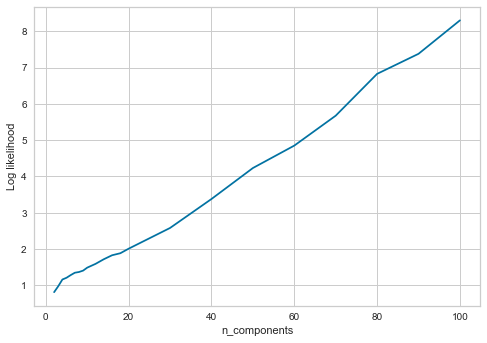

In [86]:
plt.plot(n_clusters, [em_pca_res[k]['ll'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Log likelihood')
plt.show()

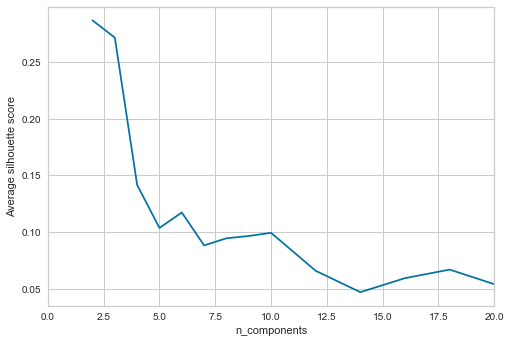

In [88]:
plt.plot(n_clusters, [em_pca_res[k]['sil'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Average silhouette score')
plt.xlim([0,20])
plt.show()

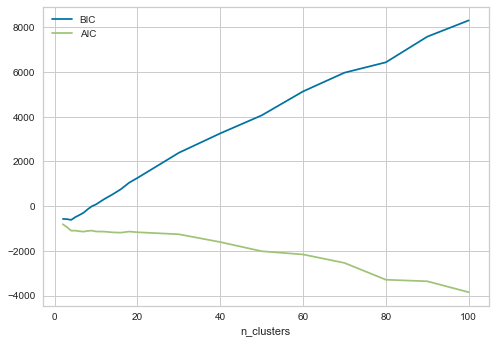

In [89]:
plt.plot(n_clusters, [em_pca_res[k]['bic'] for k in n_clusters], label='BIC')
plt.plot(n_clusters, [em_pca_res[k]['aic'] for k in n_clusters], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_clusters')
plt.show()

# EM With ICA

In [108]:
ica10 = FastICA(
    random_state=0,
    n_components=10,
)
ica10_Xt = ica10.fit_transform(X_norm)

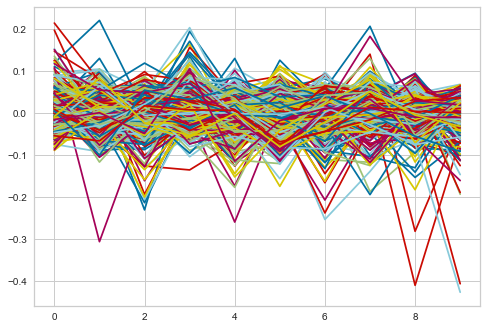

In [111]:
for d in ica10_Xt:
    plt.plot(range(len(d)), d)

In [19]:
em_ica_res = defaultdict(dict)
ica29 = FastICA(
    random_state=0,
    n_components=29,
)
ica29_Xt = ica29.fit_transform(X_preprocessed)

for k in n_clusters:
    em = GaussianMixture(
        n_components=k,
        random_state=0,
        init_params='kmeans',
    )
    start = time.perf_counter()
    em.fit(ica29_Xt)
    run_time = time.perf_counter() - start
    y_em = em.predict(ica29_Xt)
    em_ica_res[k]['bic'] = em.bic(ica29_Xt)
    em_ica_res[k]['aic'] = em.aic(ica29_Xt)
    em_ica_res[k]['ll'] = em.score(ica29_Xt)
    em_ica_res[k]['time'] = run_time
    em_ica_res[k]['sil'] = silhouette_score(ica29_Xt, y_em, random_state=0)
    print('done k=%i in %.3f sec' % (k, run_time))

joblib.dump(em_ica_res, "results/em_ica_29_cancer.pkl")

done k=2 in 0.037 sec
done k=3 in 0.049 sec
done k=4 in 0.041 sec
done k=5 in 0.064 sec
done k=6 in 0.060 sec
done k=7 in 0.068 sec
done k=8 in 0.070 sec
done k=9 in 0.062 sec
done k=10 in 0.088 sec
done k=12 in 0.154 sec
done k=14 in 0.135 sec
done k=16 in 0.144 sec
done k=18 in 0.298 sec
done k=20 in 0.133 sec
done k=30 in 0.081 sec
done k=40 in 0.146 sec
done k=50 in 0.133 sec
done k=60 in 0.067 sec
done k=70 in 0.077 sec
done k=80 in 0.093 sec
done k=90 in 0.097 sec
done k=100 in 0.111 sec


['results/em_ica_29_cancer.pkl']

In [48]:
em_ica_res = joblib.load('results/em_ica_cancer.pkl')

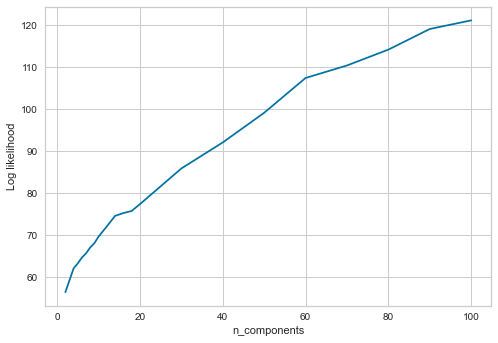

In [20]:
plt.plot(n_clusters, [em_ica_res[k]['ll'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Log likelihood')
plt.show()

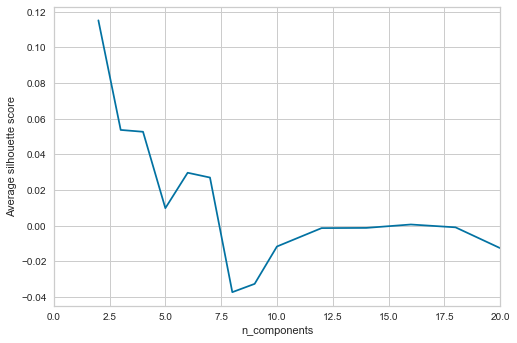

In [21]:
plt.plot(n_clusters, [em_ica_res[k]['sil'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Average silhouette score')
plt.xlim([0,20])
plt.show()

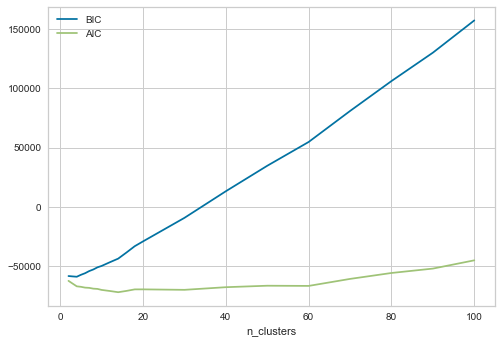

In [22]:
plt.plot(n_clusters, [em_ica_res[k]['bic'] for k in n_clusters], label='BIC')
plt.plot(n_clusters, [em_ica_res[k]['aic'] for k in n_clusters], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_clusters')
plt.show()

# EM with RP

In [95]:
em_rp_res = defaultdict(dict)
rp7 = SparseRandomProjection(n_components=7, random_state = 0)

rp7_Xt = rp7.fit_transform(X_norm)

for k in n_clusters:
    em = GaussianMixture(
        n_components=k,
        random_state=0,
        init_params='kmeans',
    )
    start = time.perf_counter()
    em.fit(rp7_Xt)
    run_time = time.perf_counter() - start
    y_em = em.predict(rp7_Xt)
    em_rp_res[k]['bic'] = em.bic(rp7_Xt)
    em_rp_res[k]['aic'] = em.aic(rp7_Xt)
    em_rp_res[k]['ll'] = em.score(rp7_Xt)
    em_rp_res[k]['time'] = run_time
    em_rp_res[k]['sil'] = silhouette_score(rp7_Xt, y_em, random_state=0)
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#         km_pca_res[k]['ami'] = ami(y, y_km)
    print('done k=%i in %.3f sec' % (k, run_time))

joblib.dump(em_rp_res, "results/em_rp_cancer.pkl")

done k=2 in 0.011 sec
done k=3 in 0.021 sec
done k=4 in 0.021 sec
done k=5 in 0.033 sec
done k=6 in 0.064 sec
done k=7 in 0.044 sec
done k=8 in 0.027 sec
done k=9 in 0.039 sec
done k=10 in 0.054 sec
done k=12 in 0.072 sec
done k=14 in 0.071 sec
done k=16 in 0.100 sec
done k=18 in 0.072 sec
done k=20 in 0.104 sec
done k=30 in 0.166 sec
done k=40 in 0.139 sec
done k=50 in 0.290 sec
done k=60 in 0.219 sec
done k=70 in 0.152 sec
done k=80 in 0.209 sec
done k=90 in 0.212 sec
done k=100 in 0.237 sec


['results/em_rp_cancer.pkl']

In [49]:
em_rp_res = joblib.load('results/em_rp_cancer.pkl')

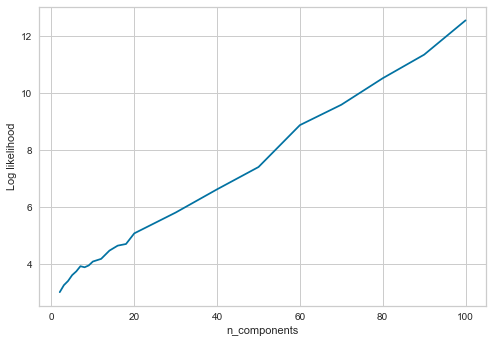

In [97]:
plt.plot(n_clusters, [em_rp_res[k]['ll'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Log likelihood')
plt.show()

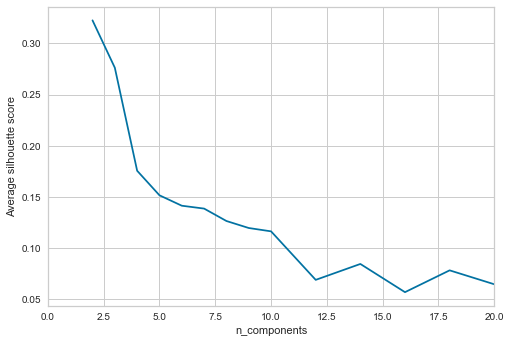

In [98]:
plt.plot(n_clusters, [em_rp_res[k]['sil'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Average silhouette score')
plt.xlim([0,20])
plt.show()

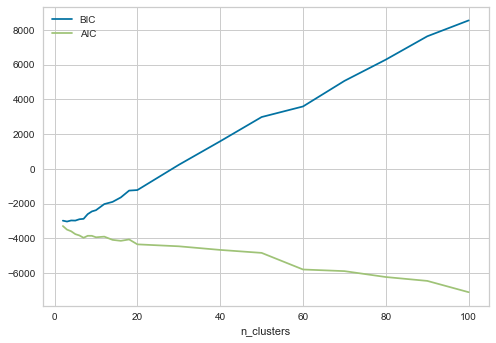

In [99]:
plt.plot(n_clusters, [em_rp_res[k]['bic'] for k in n_clusters], label='BIC')
plt.plot(n_clusters, [em_rp_res[k]['aic'] for k in n_clusters], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_clusters')
plt.show()

# EM with SVD

In [100]:
em_svd_res = defaultdict(dict)
svd6 = TruncatedSVD(n_components=6, random_state = 0)

svd6_Xt = svd6.fit_transform(X_norm)

for k in n_clusters:
    em = GaussianMixture(
        n_components=k,
        random_state=0,
        init_params='kmeans',
    )
    start = time.perf_counter()
    em.fit(svd6_Xt)
    run_time = time.perf_counter() - start
    y_em = em.predict(svd6_Xt)
    em_svd_res[k]['bic'] = em.bic(svd6_Xt)
    em_svd_res[k]['aic'] = em.aic(svd6_Xt)
    em_svd_res[k]['ll'] = em.score(svd6_Xt)
    em_svd_res[k]['time'] = run_time
    em_svd_res[k]['sil'] = silhouette_score(svd6_Xt, y_em, random_state=0)
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#         km_pca_res[k]['ami'] = ami(y, y_km)
    print('done k=%i in %.3f sec' % (k, run_time))

joblib.dump(em_svd_res, "results/em_svd_cancer.pkl")

done k=2 in 0.018 sec
done k=3 in 0.019 sec
done k=4 in 0.026 sec
done k=5 in 0.026 sec
done k=6 in 0.047 sec
done k=7 in 0.045 sec
done k=8 in 0.051 sec
done k=9 in 0.058 sec
done k=10 in 0.072 sec
done k=12 in 0.075 sec
done k=14 in 0.089 sec
done k=16 in 0.104 sec
done k=18 in 0.080 sec
done k=20 in 0.091 sec
done k=30 in 0.141 sec
done k=40 in 0.158 sec
done k=50 in 0.146 sec
done k=60 in 0.287 sec
done k=70 in 0.238 sec
done k=80 in 0.234 sec
done k=90 in 0.308 sec
done k=100 in 0.195 sec


['results/em_svd_cancer.pkl']

In [50]:
em_svd_res = joblib.load('results/em_svd_cancer.pkl')

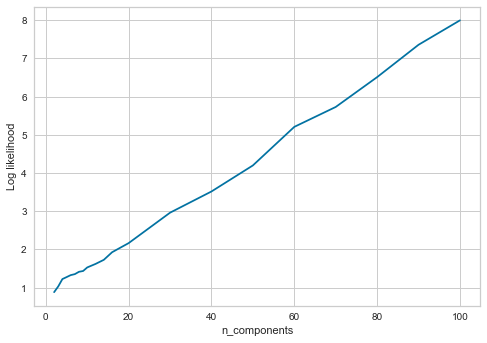

In [102]:
plt.plot(n_clusters, [em_svd_res[k]['ll'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Log likelihood')
plt.show()

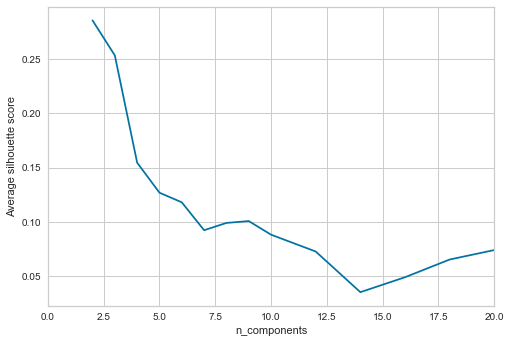

In [105]:
plt.plot(n_clusters, [em_svd_res[k]['sil'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Average silhouette score')
plt.xlim([0,20])
plt.show()

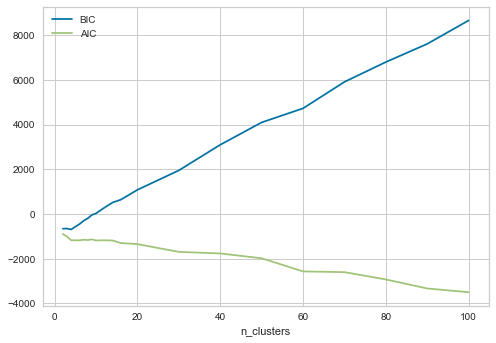

In [107]:
plt.plot(n_clusters, [em_svd_res[k]['bic'] for k in n_clusters], label='BIC')
plt.plot(n_clusters, [em_svd_res[k]['aic'] for k in n_clusters], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_clusters')
plt.show()

In [53]:
tmp = []
for i, k in enumerate(n_clusters):
    tmp.append([
        k,
        km_pca_res[k]['sil'],
        km_ica_res[k]['sil'],
        km_rp_res[k]['sil'],
        km_svd_res[k]['sil'],
        em_pca_res[k]['sil'],
        em_ica_res[k]['sil'],
        em_rp_res[k]['sil'],
        em_svd_res[k]['sil'],
    ])

In [54]:
pd.DataFrame(data=tmp, columns=[
    '# Clusters', 
    'K-Means/PCA', 
    'K-Means/ICA', 
    'K-Means/RP',
    'K-Means/SVD',
    'EM/PCA', 
    'EM/ICA', 
    'EM/RP',
    'EM/SVD',
])

,# Clusters,K-Means/PCA,K-Means/ICA,K-Means/RP,K-Means/SVD,EM/PCA,EM/ICA,EM/RP,EM/SVD
0,2,0.414112,0.132947,0.384597,0.415527,0.286512,0.153582,0.322412,0.285151
1,3,0.361205,0.143583,0.358402,0.363569,0.271310,0.089651,0.276139,0.252951
2,4,0.241130,0.076505,0.275313,0.245385,0.141615,0.029561,0.175526,0.154468
3,5,0.190786,0.066909,0.267441,0.192740,0.103774,0.039750,0.151553,0.126886
4,6,0.188792,0.081881,0.228205,0.182522,0.117397,0.050258,0.141383,0.118059
5,7,0.190260,0.078345,0.219282,0.181045,0.088389,0.045436,0.138574,0.092441
6,8,0.191800,0.080511,0.225607,0.190264,0.094665,0.058881,0.126446,0.099130
7,9,0.187724,0.082075,0.229562,0.186392,0.096701,0.044187,0.119612,0.100844
8,10,0.183625,0.086103,0.218504,0.174842,0.099467,0.041383,0.116342,0.088330
9,12,0.175575,0.091282,0.206416,0.164015,0.066036,0.027385,0.068957,0.072893
